# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

In [284]:
train = pd.read_csv('Data/Grocery/sales_train.csv.gz')
shops = pd.read_csv('Data/Grocery/shops.csv')
items = pd.read_csv('Data/Grocery/items.csv')
test = pd.read_csv('Data/Grocery/test.csv.gz').set_index('ID')
items_cats = pd.read_csv('Data/Grocery/item_categories.csv')
sub = pd.read_csv('Data/Grocery/sample_submission.csv.gz')

In [285]:
trn = train.copy()

In [286]:
trn.shape

(2935849, 6)

In [287]:
trn.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [288]:
trn.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Outliers

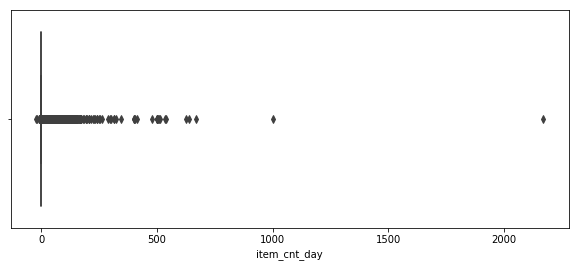

In [289]:
plt.figure(figsize=(10,4))
sns.boxplot(trn.item_cnt_day)

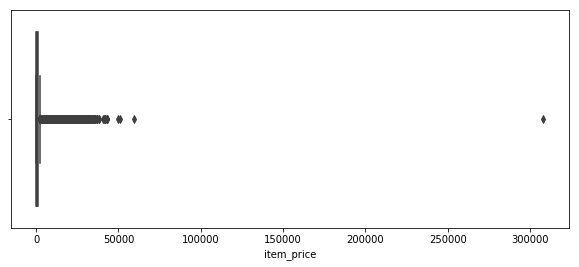

In [290]:
plt.figure(figsize=(10,4))
sns.boxplot(trn.item_price)

In [291]:
# Drop the items prices above 100,000 and number sold per day more than 1,000
trn.drop(index = [2909818, 1163158], inplace=True)

### Extract feautres from shop names and item categories

- Each shop_name starts with the city name.
- Each category contains type and subtype in its name.

In [292]:
city = shops.shop_name.str.lower().str.split().str[0]
shops['city'] = shops.shop_id.map(city)

shops['city_code'] = shops.city.factorize()[0]

In [293]:
shops.city.value_counts()

москва              13
ростовнадону         3
воронеж              3
тюмень               3
самара               2
жуковский            2
казань               2
!якутск              2
н.новгород           2
новосибирск          2
якутск               2
уфа                  2
спб                  2
красноярск           2
мытищи               1
сургут               1
химки                1
коломна              1
выездная             1
курск                1
ярославль            1
калуга               1
сергиев              1
волжский             1
цифровой             1
томск                1
вологда              1
интернет-магазин     1
омск                 1
адыгея               1
балашиха             1
чехов                1
Name: city, dtype: int64

Not my discovery but I noticed that these cities are the same (!якутск, якутск), I will rename them

In [294]:
# Renumbering the city code 0 with 30 as these are the same cities
shops.loc[shops.city_code == 0, 'city_code'] = 30

In [295]:
cat_type = items_cats.item_category_name.str.lower().str.split().str[0]
items_cats['type'] = items_cats.item_category_id.map(cat_type)

items_cats['type_code'] = items_cats['type'].factorize()[0]

In [296]:
sub_type = items_cats.item_category_name.str.lower().str.split('-').str[1]
items_cats['sub_type'] = items_cats.item_category_id.map(sub_type)

items_cats.sub_type.fillna('type', inplace=True)
items_cats['subtype_code'] = items_cats['sub_type'].factorize()[0]

In [297]:
shops = shops[['shop_id','city_code']]
items_cats = items_cats[['item_category_id','type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

### Monthly Sales

#### Create Matrix 

In [317]:
trn_df = trn[2500000:].copy()

In [318]:
matrix = []
for i in trn_df.date_block_num.unique():
    store_unique = trn_df[trn_df.date_block_num == i].shop_id.unique()
    item_unique = trn_df[trn_df.date_block_num == i].item_id.unique()
    matrix.append(np.array(list(product(*[ [i], store_unique, item_unique]))))

In [319]:
matrix = pd.DataFrame(np.vstack(matrix), columns = ['date_block_num', 'shop_id', 'item_id'])

#### Aggregate into Month

In [320]:
# Create revenue for future use
trn_df['revenue'] = trn_df.item_price * trn_df.item_cnt_day

In [321]:
temp = trn_df.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day']].sum().reset_index()
temp.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)

In [322]:
temp.item_cnt_month = temp.item_cnt_month.clip(0,20)
matrix = matrix.merge(temp, on =['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

#### Add test to train

In [323]:
test['date_block_num'] = 34

In [324]:
matrix = pd.concat([matrix, test], sort=False).fillna(0)

### Merge Shops, Items and Categories to df

In [325]:
matrix = matrix.merge(shops, on='shop_id', how='left')
matrix = matrix.merge(items, on='item_id', how='left')
matrix = matrix.merge(items_cats, on='item_category_id', how='left')

In [326]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,26,35,18972,1.0,16,37,7,19
1,26,35,18923,5.0,16,40,7,20
2,26,35,17046,3.0,16,40,7,20
3,26,35,19405,1.0,16,29,5,13
4,26,35,18873,1.0,16,37,7,19


### Adding Target Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

In [239]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,26,35,18972,1.0,16,37,7,19
1,26,35,18923,5.0,16,40,7,20
2,26,35,17046,3.0,16,40,7,20
3,26,35,19405,1.0,16,29,5,13
4,26,35,18873,1.0,16,37,7,19


In [337]:
matrix.item_cnt_month.shift()

In [316]:
lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,26,35,18972,1.0,16,37,7,19,NaN,NaN,NaN,NaN,NaN
1,26,35,18923,5.0,16,40,7,20,NaN,NaN,NaN,NaN,NaN
2,26,35,17046,3.0,16,40,7,20,NaN,NaN,NaN,NaN,NaN
3,26,35,19405,1.0,16,29,5,13,NaN,NaN,NaN,NaN,NaN
4,26,35,18873,1.0,16,37,7,19,NaN,NaN,NaN,NaN,NaN
5,26,35,18772,1.0,16,37,7,19,NaN,NaN,NaN,NaN,NaN
6,26,35,18739,1.0,16,37,7,19,NaN,NaN,NaN,NaN,NaN
7,26,35,18736,1.0,16,37,7,19,NaN,NaN,NaN,NaN,NaN
8,26,35,18704,1.0,16,55,9,34,NaN,NaN,NaN,NaN,NaN
9,26,35,7924,0.0,16,7,1,7,NaN,NaN,NaN,NaN,NaN


# Preprocessing data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level

#### Before Regularization

In [35]:
# item_mean = all_data.groupby('item_id')['Target'].mean()
# all_data['Mean'] = all_data['item_id'].map(item_mean)

In [49]:
# np.corrcoef(all_data.Mean.values, all_data.Target.values)[0][1]

0.2991337891223941

In [61]:
X_train.head()

,date_block_num,shop_id,item_id,Target,Target_mean,shop_name,item_name,item_category_id,item_category_name,Mean
0,30,2,31,0.0,0.0,"Адыгея ТЦ ""Мега""",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.556291
1,31,2,31,0.0,0.0,"Адыгея ТЦ ""Мега""",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.556291
2,32,2,31,0.0,0.0,"Адыгея ТЦ ""Мега""",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.556291
3,33,2,31,1.0,1.0,"Адыгея ТЦ ""Мега""",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.556291
4,30,18,31,0.0,0.0,"Красноярск ТЦ ""Июнь""",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.556291


#### Add text size to text features

In [20]:
df=all_data.copy()

In [21]:
def text_count(df, col):
    df[col+'_size'] = df[col].str.len()

In [22]:
text_count(df, 'shop_name')
text_count(df, 'item_name')
text_count(df, 'item_category_name')

#### Distinct word Count

In [23]:
def word_count(df, col):
    df[col+'_count'] = df[col].str.lower().str.split().str.len()

In [24]:
word_count(df, 'shop_name')
word_count(df, 'item_name')
word_count(df, 'item_category_name')

#### Add Count Frequency to text features

In [25]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [34]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
feat_count = 25
txt_vect = feature_extraction.text.TfidfVectorizer(max_features=feat_count)

In [36]:
columns = ['shop_name', 'item_name', 'item_category_name']

for col in columns:
    item_cat_tf = txt_vect.fit_transform(df[col])
    df_temp = pd.DataFrame(item_cat_tf.toarray(), columns=txt_vect.get_feature_names())
    for i in df_temp.columns:
        df[col+'_tf_' + str(i)] = df_temp[i]

In [37]:
df.shape

(762113, 90)

#### Label Encoding

In [38]:
df_encode = df.copy()

In [39]:
for i in df_encode.columns:
    df_encode[i] = df_encode[i].factorize()[0]

In [40]:
bag = {}
for num, col_1  in enumerate(df_encode.columns):
    for col_2 in df_encode.columns[num+1:]:
        if col_2 not in bag and np.all(df_encode[col_2] == df_encode[col_1]):
            bag[col_1] = col_2

In [41]:
bag

{'shop_id': 'shop_name',
 'item_id': 'item_name',
 'item_category_id': 'item_category_name',
 'shop_name_tf_курск': 'shop_name_tf_пушкинский',
 'item_category_name_tf_blu': 'item_category_name_tf_ray',
 'item_category_name_tf_cd': 'item_category_name_tf_производства'}

In [42]:
bag.values()

dict_values(['shop_name', 'item_name', 'item_category_name', 'shop_name_tf_пушкинский', 'item_category_name_tf_ray', 'item_category_name_tf_производства'])

In [45]:
df.drop(bag.values(), axis = 1, inplace=True)

In [47]:
df.shape

(762113, 84)

In [49]:
# df_encode.drop(df_encode.index, inplace=True)

Steps to improve model:
1. Knowing this in Russia, add the bank and the school holidays
2. Add features that display the summer season, christmas and other important holidays or peak seasons in russia
3. check whether some items wherein specific discount and check sales relevant to them
4. Are same products sold for different prices in different stores
5. Price fluctuations over this period, does this affect the prcie?
6. How about stores that have closed, example shop 23
7. #### Check whether some data can point to a sales/marketing campaign, and add it as a feature then add days of saledate-campaign date as a new feature

In [50]:
display_all(df.head())

,date_block_num,shop_id,item_id,Target,Target_mean,item_category_id,shop_name_size,item_name_size,item_category_name_size,shop_name_count,item_name_count,item_category_name_count,shop_name_tf_ii,shop_name_tf_воронеж,shop_name_tf_к7,shop_name_tf_курск,shop_name_tf_магазин,shop_name_tf_мега,shop_name_tf_молл,shop_name_tf_москва,shop_name_tf_мтрц,shop_name_tf_новгород,shop_name_tf_новосибирск,shop_name_tf_паркхаус,shop_name_tf_рио,shop_name_tf_ростовнадону,shop_name_tf_с21,shop_name_tf_самара,shop_name_tf_тк,shop_name_tf_трк,shop_name_tf_трц,shop_name_tf_тц,shop_name_tf_тюмень,shop_name_tf_уфа,shop_name_tf_центральный,shop_name_tf_якутск,item_name_tf_1с,item_name_tf_360,item_name_tf_3d,item_name_tf_bd,item_name_tf_cd,item_name_tf_edition,item_name_tf_jewel,item_name_tf_mp3,item_name_tf_of,item_name_tf_pc,item_name_tf_ps3,item_name_tf_the,item_name_tf_xbox,item_name_tf_арт,item_name_tf_версия,item_name_tf_для,item_name_tf_игра,item_name_tf_коллекция,item_name_tf_настольная,item_name_tf_регион,item_name_tf_русская,item_name_tf_русские,item_name_tf_субтитры,item_name_tf_фигурка,item_name_tf_цифровая,item_category_name_tf_360,item_category_name_tf_blu,item_category_name_tf_cd,item_category_name_tf_dvd,item_category_name_tf_pc,item_category_name_tf_ps3,item_category_name_tf_xbox,item_category_name_tf_атрибутика,item_category_name_tf_аудиокниги,item_category_name_tf_винил,item_category_name_tf_игры,item_category_name_tf_издания,item_category_name_tf_кино,item_category_name_tf_книги,item_category_name_tf_локального,item_category_name_tf_музыка,item_category_name_tf_настольные,item_category_name_tf_подарки,item_category_name_tf_программы,item_category_name_tf_стандартные,item_category_name_tf_сувениры,item_category_name_tf_фигурки,item_category_name_tf_цифра
0,30,2,31,0.0,0.0,37,16,31,14,3,4,3,0.0,0.0,0.0,0.0,0.0,0.866732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31,2,31,0.0,0.0,37,16,31,14,3,4,3,0.0,0.0,0.0,0.0,0.0,0.866732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32,2,31,0.0,0.0,37,16,31,14,3,4,3,0.0,0.0,0.0,0.0,0.0,0.866732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33,2,31,1.0,1.0,37,16,31,14,3,4,3,0.0,0.0,0.0,0.0,0.0,0.866732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,18,31,0.0,0.0,37,20,31,14,3,4,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
